___
**設定：Setting**

In [2]:
# 建物レベル最適運転計画（簡潔版）
# - 入力: ac_control_processed_Clea.csv, power_meter_processed_Clea.csv
# - 出力: 予測モデル（MultiOutput）で室内温度/電力を予測し、天気予報に基づき簡易に最適計画を算出
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# 建物レベル横持ち特徴量の作成 + 単一モデル(XGBoost)学習（多出力）
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# Safe JP font setup without warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
import warnings

# 使える候補（環境にあるものを自動選択）
preferred = [
    "Hiragino Sans",            # macOS
    "Hiragino Kaku Gothic ProN",
    "Yu Gothic",                # Windows
    "MS Gothic",
    "AppleGothic",              # macOS 代替
    "Arial Unicode MS",         # 広範囲
    "DejaVu Sans",              # 最終手段（英数・一部日本語）
]

# システムフォント一覧から存在チェック
available = set(font_manager.get_font_names())
font_name = next((f for f in preferred if f in available), "DejaVu Sans")

# 参照しない（存在しないフォント名をrcParamsから除外）
mpl.rcParams["font.family"] = font_name
mpl.rcParams["font.sans-serif"] = [font_name]
mpl.rcParams["axes.unicode_minus"] = False

# 旧セルで指定した未インストール名をクリア（必要なら）
for k in ["font.family", "font.sans-serif"]:
    mpl.rcParams[k] = [font_name]

# findfont の警告を抑制
mpl.set_loglevel("error")
warnings.filterwarnings("ignore", message=r"findfont: Font family '.*' not found")

print(f"Using font: {font_name}")


# プロジェクトルート
cwd = Path.cwd()
project_root = cwd.parent if cwd.name == 'notebooks' else cwd
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print('Project root:', project_root)



Using font: Hiragino Sans
Project root: /Users/toukouken/Documents/MENTERU/AIrux8_opti_logic


In [2]:
# パス設定（必要に応じて変更）
DATA_DIR = project_root / 'data/02_PreprocessedData/Clea'
AC_CONTROL_CSV = DATA_DIR / 'ac_control_processed_Clea.csv'
POWER_METER_CSV = DATA_DIR / 'power_meter_processed_Clea.csv'

# 天気予報（本来はAPI取得、ここでは簡潔のため既存の予報CSVを指定可能）
FORECAST_CSV = project_root / 'data/04_PlanningData/Clea/weather_forecast_20250929_20251004.csv'

print('AC control:', AC_CONTROL_CSV)
print('Power:', POWER_METER_CSV)
print('Forecast:', FORECAST_CSV)


AC control: /Users/toukouken/Documents/MENTERU/AIrux8_opti_logic/data/02_PreprocessedData/Clea/ac_control_processed_Clea.csv
Power: /Users/toukouken/Documents/MENTERU/AIrux8_opti_logic/data/02_PreprocessedData/Clea/power_meter_processed_Clea.csv
Forecast: /Users/toukouken/Documents/MENTERU/AIrux8_opti_logic/data/04_PlanningData/Clea/weather_forecast_20250929_20251004.csv


___
**前処理：pre-Processing**

In [3]:
# 計測ユーティリティ
import time, cProfile, pstats, io

def section_time(label, func, *args, **kwargs):
    t0 = time.perf_counter(); out = func(*args, **kwargs); dt = time.perf_counter() - t0
    print(f"[TIME] {label}: {dt:.2f}s"); return out

def profile_block(run_callable, sort_by="cumtime", lines=30):
    pr = cProfile.Profile(); pr.enable();
    run_callable();
    pr.disable(); s = io.StringIO(); pstats.Stats(pr, stream=s).sort_stats(sort_by).print_stats(lines)
    print(s.getvalue())


In [4]:
# データ読み込みと前処理（簡潔版）
assert AC_CONTROL_CSV.exists(), f'not found: {AC_CONTROL_CSV}'
assert POWER_METER_CSV.exists(), f'not found: {POWER_METER_CSV}'

ac = pd.read_csv(AC_CONTROL_CSV)
pw = pd.read_csv(POWER_METER_CSV)

# 列名BOM除去と datetime 統一
ac.columns = ac.columns.str.replace('\ufeff', '')
pw.columns = pw.columns.str.replace('\ufeff', '')

datetime_col = 'Datetime' if 'Datetime' in ac.columns else 'datetime'
ac[datetime_col] = pd.to_datetime(ac[datetime_col])
pw[datetime_col] = pd.to_datetime(pw[datetime_col])

# 時刻列を統一
ac['Datetime'] = ac['Datetime'] if 'Datetime' in ac.columns else ac['datetime']
ac['Datetime'] = pd.to_datetime(ac['Datetime'])

# 室内機の識別（unit_id or indoor_id 的な列名推定）
UNIT_ID = "A/C Name"
# 固定順のユニット一覧
units_fixed = sorted(ac[UNIT_ID].dropna().unique().tolist())
units_fixed

['A-25',
 'A-26',
 'D-1南1',
 'D-2北1',
 'D-3南2',
 'D-4北2',
 'D-5南1',
 'D-6北1',
 'D-7南2',
 'D-8北2',
 'E-10南2',
 'E-11南3',
 'E-12南4',
 'E-13北1',
 'E-14北2',
 'E-15北3',
 'E-16北4',
 'E-17',
 'E-9南1',
 'F-18',
 'F-19',
 'F-20',
 'G-21',
 'G-22',
 'G-23',
 'G-24']

In [5]:
# 必要そうな列の推定
col_map = {
    'set_temp': None,
    'mode': None,
    'fan': None,
    'onoff': None,
    'indoor_temp': None,
    'outdoor_temp': None,
    'solar': None,
}
for c in ac.columns:
    cl = c.lower()
    if col_map['set_temp'] is None and ('set' in cl and 'temp' in cl): col_map['set_temp'] = c
    if col_map['mode'] is None and 'mode' in cl: col_map['mode'] = c
    if col_map['fan'] is None and 'fan' in cl: col_map['fan'] = c
    if col_map['onoff'] is None and ('on/off' in cl or 'on_off' in cl or 'onoff' in cl or 'a/c on/off' in cl): col_map['onoff'] = c
    if col_map['indoor_temp'] is None and ('indoor' in cl and 'temp' in cl): col_map['indoor_temp'] = c
    if col_map['outdoor_temp'] is None and ('outdoor' in cl and 'temp' in cl): col_map['outdoor_temp'] = c
    if col_map['solar'] is None and ('solar' in cl): col_map['solar'] = c

In [6]:
from datetime import datetime

import pandas as pd
from prettytable import PrettyTable


class DataManager:
    @classmethod
    def show_status(self, df: pd.DataFrame):
        table = PrettyTable(
            ["Variable", "Type", "Missing Values", "Duplicates", "Outliers"]
        )

        for col in df.columns:
            # データ型の判定
            if pd.api.types.is_numeric_dtype(df[col]):
                col_type = "Numerical"
            else:
                col_type = "Categorical"

            # 欠損値
            missing_values = df[col].isnull().sum()

            # 重複数
            duplicates = df.duplicated(subset=[col]).sum()

            # 外れ値（数値型のみ）
            if col_type == "Numerical":
                mean = df[col].mean()
                std = df[col].std()
                outliers = ((df[col] - mean).abs() > 3 * std).sum()
            else:
                outliers = "N/A"

            table.add_row([col, col_type, missing_values, duplicates, outliers])
        print(table)

    @classmethod
    def extract_term_data(
        cls, target_col: str, df: pd.DataFrame, start_time: datetime, end_time: datetime
    ):
        df[target_col] = pd.to_datetime(df[target_col])
        filtered_df = df[(df[target_col] >= start_time) & (df[target_col] <= end_time)]
        return filtered_df

    @classmethod
    def check_date_sequence(cls, df: pd.DataFrame, date_col: str = "date"):
        dates = pd.to_datetime(df[date_col]).sort_values().reset_index(drop=True)
        expected = pd.date_range(start=dates.min(), end=dates.max(), freq="D")
        missing = expected.difference(dates)
        return {
            "is_continuous": len(missing) == 0,
            "missing_dates": missing.strftime("%Y-%m-%d").tolist(),
        }


In [7]:
DataManager.show_status(ac)
print(len(ac))

+---------------------+-------------+----------------+------------+----------+
|       Variable      |     Type    | Missing Values | Duplicates | Outliers |
+---------------------+-------------+----------------+------------+----------+
|       Datetime      | Categorical |       0        |  3205254   |   N/A    |
|         Date        | Categorical |       0        |  3335400   |   N/A    |
|       A/C Name      | Categorical |       0        |  3335830   |   N/A    |
|    Outdoor Temp.    |  Numerical  |       0        |  3335811   |    0     |
|     Indoor Temp.    |  Numerical  |       0        |  3335810   |  13070   |
| A/C Set Temperature |  Numerical  |       0        |  3335838   |  13510   |
|      A/C ON/OFF     | Categorical |       0        |  3335854   |   N/A    |
|       A/C Mode      | Categorical |     44361      |  3335852   |   N/A    |
|    A/C Fan Speed    | Categorical |    2352277     |  3335850   |   N/A    |
|  Naive Energy Level |  Numerical  |       0       

In [8]:
DataManager.show_status(pw)
print(len(pw))

+------------+-------------+----------------+------------+----------+
|  Variable  |     Type    | Missing Values | Duplicates | Outliers |
+------------+-------------+----------------+------------+----------+
|  Datetime  | Categorical |       0        |  1869023   |   N/A    |
|    Date    | Categorical |       0        |  2517503   |   N/A    |
|  Mesh ID   |  Numerical  |       0        |  2517955   |    0     |
| PM Addr ID |  Numerical  |       0        |  2517950   |    0     |
|  Phase A   |  Numerical  |       0        |  2515287   |  67473   |
|  Phase B   |  Numerical  |       0        |  2517958   |    0     |
|  Phase C   |  Numerical  |       0        |  2517958   |    0     |
| Total_kWh  |  Numerical  |       0        |  2515287   |  67473   |
+------------+-------------+----------------+------------+----------+
2517959


In [9]:
# 室内機(ac)・室外機(pw)をグルーピングして、時刻別（時刻×ユニット）の横持ちテーブルに変換

import pandas as pd
import numpy as np

# 1) 時刻列を統一＆時単位に丸め
def to_hourly(df, dt_col):
    df = df.copy()
    df[dt_col] = pd.to_datetime(df[dt_col])
    df['Datetime_hour'] = df[dt_col].dt.floor('H')
    return df

# 2) 室内機（A/C Name）× 時刻で集約 → 横持ち
#    - 集約指標の例:
#      set_temp: 平均, mode/fan/onoff: 最頻値, indoor_temp: 平均
def pivot_indoor(ac: pd.DataFrame,
                 unit_col='A/C Name',
                 dt_col='Datetime',
                 set_temp_col=None,
                 mode_col=None,
                 fan_col=None,
                 onoff_col=None,
                 indoor_temp_col=None):
    ac1 = to_hourly(ac, dt_col)

    agg_map = {}
    if set_temp_col:     agg_map[set_temp_col] = 'mean'
    if indoor_temp_col:  agg_map[indoor_temp_col] = 'mean'
    # 最頻値集計（mode/fan/onoff）
    def mode_agg(s):
        s = pd.to_numeric(s, errors='coerce')
        s = s.dropna().astype(int)
        return s.mode().iloc[0] if len(s) else np.nan
    if mode_col:         agg_map[mode_col] = mode_agg
    if fan_col:          agg_map[fan_col] = mode_agg
    if onoff_col:        agg_map[onoff_col] = mode_agg

    g = (ac1
         .groupby(['Datetime_hour', unit_col], as_index=False)
         .agg(agg_map))

    # wide化（列名: 指標__ユニット）
    wide_parts = []
    for col, fn in agg_map.items():
        p = g.pivot(index='Datetime_hour', columns=unit_col, values=col)
        p.columns = [f'{col}__{c}' for c in p.columns]
        wide_parts.append(p)
    ac_wide = pd.concat(wide_parts, axis=1).sort_index()
    return ac_wide  # index=時刻(時), columns= 指標__A/C Name

# 3) 室外機（Mesh ID + PM Addr ID）× 時刻で集約 → 横持ち
#    - Phaseは無視、Total_kWhを合計
def pivot_outdoor(pw: pd.DataFrame,
                  dt_col='Datetime',
                  mesh_col='Mesh ID',
                  addr_col='PM Addr ID',
                  kwh_col='Total_kWh'):
    pw1 = to_hourly(pw, dt_col).copy()
    # 室外機ID生成
    pw1['ODU_ID'] = pw1[mesh_col].astype(str) + '-' + pw1[addr_col].astype(str)
    # 時刻×ODUで合計
    kwh_actual_col = kwh_col if kwh_col in pw1.columns else ('Total_KWh' if 'Total_KWh' in pw1.columns else None)
    if kwh_actual_col is None:
        raise ValueError('Total_kWh (or Total_KWh) 列が見つかりません')
    g = (pw1
         .groupby(['Datetime_hour','ODU_ID'], as_index=False)[kwh_actual_col]
         .sum())
    pw_wide = g.pivot(index='Datetime_hour', columns='ODU_ID', values=kwh_actual_col)
    pw_wide.columns = [f'total_kwh__{c}' for c in pw_wide.columns]
    pw_wide = pw_wide.sort_index()
    return pw_wide  # index=時刻(時), columns= total_kwh__ODU_ID

# 4) 使い方例
# 室内機側の列名をプロジェクトに合わせて指定してください
ac_wide = pivot_indoor(
    ac,
    unit_col='A/C Name',
    dt_col='Datetime' if 'Datetime' in ac.columns else 'datetime',
    set_temp_col=col_map.get('set_temp'),
    mode_col=col_map.get('mode'),
    fan_col=col_map.get('fan'),
    onoff_col=col_map.get('onoff'),
    indoor_temp_col=col_map.get('indoor_temp')
)

# 室外機側
pw_wide = pivot_outdoor(
    pw,
    dt_col='Datetime' if 'Datetime' in pw.columns else 'datetime',
    mesh_col='Mesh ID',
    addr_col='PM Addr ID',
    kwh_col='Total_kWh'  # or 'Total_KWh'
)

# 5) 時刻キーで突き合わせ（必要なら）
hourly_merged = ac_wide.join(pw_wide, how='outer').sort_index()
print(ac_wide.shape, pw_wide.shape, hourly_merged.shape)

/var/folders/8l/p7_mk6qs1y9dsdvmzt6qd68w0000gn/T/ipykernel_5839/3639000614.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Datetime_hour'] = df[dt_col].dt.floor('H')
/var/folders/8l/p7_mk6qs1y9dsdvmzt6qd68w0000gn/T/ipykernel_5839/3639000614.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Datetime_hour'] = df[dt_col].dt.floor('H')


(10894, 130) (10833, 21) (10896, 151)


___
**学習用に欠損を処理**

In [11]:
DataManager.show_status(hourly_merged)
print(len(hourly_merged))

+------------------------------+-----------+----------------+------------+----------+
|           Variable           |    Type   | Missing Values | Duplicates | Outliers |
+------------------------------+-----------+----------------+------------+----------+
|  A/C Set Temperature__A-25   | Numerical |      245       |   10804    |    0     |
|  A/C Set Temperature__A-26   | Numerical |      245       |   10821    |   245    |
| A/C Set Temperature__D-1南1  | Numerical |      135       |   10808    |    10    |
| A/C Set Temperature__D-2北1  | Numerical |      134       |   10811    |   311    |
| A/C Set Temperature__D-3南2  | Numerical |      134       |   10808    |    50    |
| A/C Set Temperature__D-4北2  | Numerical |      134       |   10799    |   226    |
| A/C Set Temperature__D-5南1  | Numerical |      134       |   10805    |    0     |
| A/C Set Temperature__D-6北1  | Numerical |      134       |   10805    |    0     |
| A/C Set Temperature__D-7南2  | Numerical |      134       |

In [ ]:
# hourly_merged.to_csv("../data/base/hourly_merged.csv", index = False)

# 機械学習モデルの開発

## 欠損値補完

In [3]:
hourly_merged = pd.read_csv("../data/base/hourly_merged.csv")

In [ ]:
# hourly_merged の欠損処理（要件に合わせた順序）
hourly_merged_filled = hourly_merged.copy()

# 1) onoff__* が欠損している行を除外
onoff_cols = [c for c in hourly_merged_filled.columns if c.startswith('onoff__')]
if onoff_cols:
    onoff_mask = hourly_merged_filled[onoff_cols].notna().all(axis=1)
    hourly_merged_filled = hourly_merged_filled[onoff_mask].copy()

# 2) 電力列（total_kwh__*）の欠損を0で埋める
kwh_cols = [c for c in hourly_merged_filled.columns if c.startswith('total_kwh__')]
if kwh_cols:
    hourly_merged_filled[kwh_cols] = hourly_merged_filled[kwh_cols].fillna(0)

# 3) 空調列（set_temp/mode/fan/indoor_temp）を時刻でソート（前値補完のため）
hourly_merged_filled = hourly_merged_filled.sort_index()

# 4) 空調列について、onoff==0 の場合に前値補完
ac_vars = ['set_temp__', 'mode__', 'fan__', 'indoor_temp__']

for prefix in ac_vars:
    ac_cols = [c for c in hourly_merged_filled.columns if c.startswith(prefix)]
    for col in ac_cols:
        # 対応する onoff 列を特定（同じ室内機名を抽出）
        unit_suffix = col.split('__', 1)[1] if '__' in col else ''
        onoff_col = f'onoff__{unit_suffix}' if unit_suffix else None
        
        if onoff_col and onoff_col in hourly_merged_filled.columns:
            # onoff == 0 かつ その列が欠損 → 前値補完
            off_mask = pd.to_numeric(hourly_merged_filled[onoff_col], errors='coerce') == 0
            nan_mask = hourly_merged_filled[col].isna()
            fill_mask = off_mask & nan_mask
            
            if fill_mask.any():
                hourly_merged_filled[col] = hourly_merged_filled[col].ffill()  # fillna(method='ffill') を .ffill() に変更

# 5) 最終削除
hourly_merged_filled = hourly_merged_filled.dropna(axis=1)

# 6) 最終チェック: 時刻でソート済み、欠損処理完了
hourly_merged_filled = hourly_merged_filled.sort_index()
print(f'処理後: {len(hourly_merged_filled)}行')
print(f'残存欠損値: {hourly_merged_filled.isna().sum().sum()} 個')

処理後: 10896行
残存欠損値: 0 個


___
**予測モデル構築：ML-modeling**

In [243]:
hourly_merged_filled

,total_kwh__41-1,total_kwh__43-1,total_kwh__43-2,total_kwh__43-3,total_kwh__43-4,total_kwh__44-1,total_kwh__44-2,total_kwh__44-3,total_kwh__44-4,total_kwh__44-5,...,total_kwh__44-7,total_kwh__44-8,total_kwh__49-1,total_kwh__49-2,total_kwh__49-3,total_kwh__49-4,total_kwh__49-6,total_kwh__49-7,total_kwh__49-8,total_kwh__49-9
Datetime_hour,,,,,,,,,,,,,,,,,,,,,
2024-06-30 15:00:00,120.0,0.0,975.0,360.0,2145.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2700.0,390.0,195.0,325.0,420.0,520.0,695.0,610.0,770.0
2024-06-30 16:00:00,120.0,0.0,1170.0,750.0,1105.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1540.0,390.0,325.0,260.0,240.0,455.0,700.0,575.0,1050.0
2024-06-30 17:00:00,120.0,0.0,1495.0,390.0,1560.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2700.0,390.0,325.0,65.0,185.0,455.0,420.0,380.0,1820.0
2024-06-30 18:00:00,120.0,0.0,780.0,390.0,2275.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1510.0,195.0,520.0,325.0,480.0,130.0,400.0,605.0,1260.0
2024-06-30 19:00:00,120.0,0.0,1625.0,330.0,1560.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2700.0,260.0,515.0,390.0,360.0,260.0,485.0,480.0,1190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-27 21:00:00,120.0,9135.0,185.0,155.0,585.0,390.0,415.0,520.0,135.0,26985.0,...,845.0,0.0,520.0,715.0,520.0,600.0,325.0,420.0,245.0,560.0
2025-09-27 22:00:00,120.0,9415.0,195.0,175.0,515.0,325.0,270.0,455.0,45.0,28305.0,...,1495.0,0.0,195.0,390.0,715.0,185.0,650.0,630.0,570.0,630.0
2025-09-27 23:00:00,120.0,11230.0,2790.0,680.0,2455.0,520.0,215.0,260.0,10.0,20020.0,...,1690.0,0.0,845.0,775.0,390.0,430.0,325.0,420.0,120.0,630.0


In [109]:
# ===== Targets (Y): ODU energy (Total_kWh per ODU) + per-unit indoor temperature =====

# 前提:
# - pw: ['Datetime','Mesh ID','PM Addr ID','Total_kWh'] を含む（Phaseは使わない）
# - ac: ['Datetime','A/C Name', <indoor temp column>] を含む
# - UNIT_ID = 'A/C Name' が設定済み
# - pivot_wide(df, value_col) が利用可能（index='Datetime', columns=UNIT_ID で横持ち）

# 1) 室外機（ODU）別 Total_kWh を横持ち
assert {'Datetime','Mesh ID','PM Addr ID'}.issubset(pw.columns), "pw: 必須列不足"
kwh_col = 'Total_KWh' if 'Total_KWh' in pw.columns else 'Total_kWh'
assert kwh_col in pw.columns, "pw: Total_kWh 列がありません"

pw['Datetime'] = pw['Datetime'] if 'Datetime' in pw.columns else pw['datetime']
pw['Datetime'] = pd.to_datetime(pw['Datetime'])
pw['ODU_ID'] = pw['Mesh ID'].astype(str) + '-' + pw['PM Addr ID'].astype(str)

pw_odu = (pw[['Datetime','ODU_ID', kwh_col]]
          .dropna()
          .groupby(['Datetime','ODU_ID'], as_index=False)[kwh_col].sum())

Y_odu = (pw_odu
         .pivot(index='Datetime', columns='ODU_ID', values=kwh_col)
         .sort_index())
Y_odu.columns = [f"total_kwh__{c}" for c in Y_odu.columns]

# 2) 室内機（A/C Name）別 室内温度を横持ち
#    col_map['indoor_temp'] が検出できていること
assert col_map['indoor_temp'] is not None, "ac: 室内温度の列が検出できていません"
ac['Datetime'] = ac['Datetime'] if 'Datetime' in ac.columns else ac['datetime']
ac['Datetime'] = pd.to_datetime(ac['Datetime'])

Y_ind = pivot_wide(
    ac[['Datetime', UNIT_ID, col_map['indoor_temp']]].rename(
        columns={col_map['indoor_temp']: 'indoor_temp'}
    ),
    'indoor_temp'
).sort_index()

# 3) 目的変数の結合（同一時刻に存在する行のみ）
Y = Y_odu.join(Y_ind, how='inner').dropna()

# 4) 学習データ作成（Xは既存のユニット横持ち + 外気）
XY = X.join(Y, how='inner').dropna()
X_mat = XY[X.columns].apply(pd.to_numeric, errors='coerce').fillna(0).values
Y_mat = XY[Y.columns].values

n_train = int(len(X_mat)*0.8)
X_tr, X_te, Y_tr, Y_te = X_mat[:n_train], X_mat[n_train:], Y_mat[:n_train], Y_mat[n_train:]

# 5) 学習（XGBoost MultiOutput）
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, tree_method='hist',
        n_jobs=-1, random_state=42
    )
)
model.fit(X_tr, Y_tr)
Y_pred = model.predict(X_te)

print('R2 per target:', [r2_score(Y_te[:,i], Y_pred[:,i]) for i in range(Y_mat.shape[1])])
print('MAE per target:', [mean_absolute_error(Y_te[:,i], Y_pred[:,i]) for i in range(Y_mat.shape[1])])

# 6) 以降の推論/可視化で列名を使いたい場合
target_cols = list(Y.columns)  # 例: ['total_kwh__<ODU1>', ..., 'indoor_temp__<A/C Name1>', ...]

ValueError: Found array with 0 sample(s) (shape=(0, 47)) while a minimum of 1 is required by MultiOutputRegressor.

In [ ]:
# # ピボット用関数
# def pivot_wide(df, value_col):
#     wide = df.pivot_table(index='Datetime', columns=UNIT_ID, values=value_col, aggfunc='last')
#     wide = wide.reindex(columns=units_fixed)
#     wide.columns = [f"{value_col}__{u}" for u in wide.columns]
#     return wide

# # ユニット別入力特徴
# pieces = []
# if col_map['set_temp']:
#     pieces.append(pivot_wide(ac[['Datetime', UNIT_ID, col_map['set_temp']]].rename(columns={col_map['set_temp']:'set_temp'}), 'set_temp'))
# if col_map['mode']:
#     pieces.append(pivot_wide(ac[['Datetime', UNIT_ID, col_map['mode']]].rename(columns={col_map['mode']:'mode'}), 'mode'))
# if col_map['fan']:
#     pieces.append(pivot_wide(ac[['Datetime', UNIT_ID, col_map['fan']]].rename(columns={col_map['fan']:'fan'}), 'fan'))
# if col_map['onoff']:
#     pieces.append(pivot_wide(ac[['Datetime', UNIT_ID, col_map['onoff']]].rename(columns={col_map['onoff']:'onoff'}), 'onoff'))
# X_units = pd.concat(pieces, axis=1).sort_index().fillna(0)

# # 環境（外気）
# env_cols = []
# if col_map['outdoor_temp']: env_cols.append(col_map['outdoor_temp'])
# if col_map['solar']:        env_cols.append(col_map['solar'])
# env_df = ac[['Datetime']+env_cols].drop_duplicates('Datetime').set_index('Datetime').sort_index()
# X = X_units.join(env_df, how='left').fillna(0)

# # 目的変数（建物総電力 + 室内温度（各ユニット別））
# pw['Datetime'] = pw['Datetime'] if 'Datetime' in pw.columns else pw['datetime']
# pw['Datetime'] = pd.to_datetime(pw['Datetime'])
# _pw = pw[['Datetime', power_col]].rename(columns={power_col:'power_wh'}).copy()
# _pw['power_kwh'] = np.where(_pw['power_wh']>2000, _pw['power_wh']/1000.0, _pw['power_wh'])
# Y_power = _pw.set_index('Datetime')[['power_kwh']].sort_index()
# Y_ind = None
# if col_map['indoor_temp']:
#     Y_ind = pivot_wide(ac[['Datetime', UNIT_ID, col_map['indoor_temp']]].rename(columns={col_map['indoor_temp']:'indoor_temp'}), 'indoor_temp')
# Y = Y_power.join(Y_ind, how='inner') if Y_ind is not None else Y_power

# XY = X.join(Y, how='inner').dropna()
# X_mat = XY[X.columns].apply(pd.to_numeric, errors='coerce').fillna(0).values
# Y_mat = XY[Y.columns].values
# n_train = int(len(X_mat)*0.8)
# X_tr, X_te, Y_tr, Y_te = X_mat[:n_train], X_mat[n_train:], Y_mat[:n_train], Y_mat[n_train:]

# model = MultiOutputRegressor(
#     XGBRegressor(
#         n_estimators=600,
#         learning_rate=0.05,
#         max_depth=6,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         tree_method='hist',
#         n_jobs=-1,
#         random_state=42,
#     )
# )
# section_time('XGB 学習', model.fit, X_tr, Y_tr)
# Y_pred = model.predict(X_te)
# print('R2 per target:', [r2_score(Y_te[:,i], Y_pred[:,i]) for i in range(Y_mat.shape[1])])
# print('MAE per target:', [mean_absolute_error(Y_te[:,i], Y_pred[:,i]) for i in range(Y_mat.shape[1])])


[TIME] XGB 学習: 176.89s
R2 per target: [-0.2701888617844934, 0.037741961807961744, -0.9613808124906469, 0.17157999167234317, -0.14163961668372704, -0.05018077123160847, -0.04888925370992103, 0.007169261982160946, 0.1694100972295498, -0.18715814988504564, -0.4693777406841384, -0.33791994122282354, -0.32441196581859333, -0.33334966482122286, -0.005899555029617254, -0.19890604302223602, -0.5094331629948836, -0.05093165213983686, -1.2503622179712908, -0.6544132718967022, -0.6646218639301027, -4.045921205969465, -3.1309123363040676, 0.0794362559761016, -1.2531747173237666, 0.6880298977643914, 0.4565558730523208]
MAE per target: [584.097358364359, 2.585622901359057, 2.8635899928778263, 2.6309775077004987, 4.083799718937041, 1.4802359981892277, 2.328773310902844, 2.590726219994887, 2.3194988782370283, 2.6630645601847274, 3.5877606619848854, 2.839074629152162, 3.4670893063235653, 3.8746745035614625, 2.9619827782019965, 2.7491833598092543, 3.5614743521863774, 3.1559039909119417, 3.16867308374604

In [168]:
# 天気予報の読み込み（簡潔）と最適計画探索（貪欲）
assert FORECAST_CSV.exists(), f'not found: {FORECAST_CSV}'
fc = pd.read_csv(FORECAST_CSV)
fc.columns = fc.columns.str.replace('\ufeff','')
# 予報側: datetime, Outdoor Temp., Solar Radiation を想定
if 'datetime' in fc.columns:
    fc['datetime'] = pd.to_datetime(fc['datetime'])
elif 'Datetime' in fc.columns:
    fc['datetime'] = pd.to_datetime(fc['Datetime'])
else:
    raise ValueError('forecast datetime列が見つかりません')

# 列推定
fc_temp_col = None
fc_solar_col = None
for c in fc.columns:
    cl = c.lower()
    if fc_temp_col is None and ('outdoor' in cl and 'temp' in cl): fc_temp_col = c
    if fc_solar_col is None and 'solar' in cl: fc_solar_col = c
assert fc_temp_col is not None, 'forecast outdoor temp 列が見つかりません'
# solar任意

In [171]:
# 共通条件での一括予測（全室内機 同じ set/mode/fan/onoff）
# 前提: すでに学習済み model と特徴量 X、予報 fc があること

# 1) 列群の取得
mode_cols = [c for c in X.columns if c.startswith('mode__')]
fan_cols  = [c for c in X.columns if c.startswith('fan__')]
on_cols   = [c for c in X.columns if c.startswith('onoff__')]
set_cols  = [c for c in X.columns if c.startswith('set_temp__')]

# 2) 共通条件パラメータ（必要に応じて変更）
UNIFORM = dict(
    set_temp=26,   # 全室内機の設定温度
    mode=1,        # 例: COOL=1 等（実データのコードに合わせて）
    fan=1,         # 例: LOW=1 等（実データのコードに合わせて）
    units_on=None  # None=全台ON, 数値ならその台数のみON
)

# 3) 予報の並び替えとテンプレート行
fc_sorted = fc.sort_values('datetime').copy()
T = len(fc_sorted)
template = pd.DataFrame(np.zeros((T, len(X.columns))), columns=X.columns)

# 4) 外気条件のコピー（列名は実データに合わせて）
# 例: Xに 'Outdoor Temp.' があれば fcの fc_temp_col を対応付け
if col_map['outdoor_temp']:
    template[col_map['outdoor_temp']] = pd.to_numeric(fc_sorted[fc_temp_col], errors='coerce').values
if col_map['solar'] and ('forecast_solar_radiation' in fc_sorted.columns or fc_solar_col):
    if fc_solar_col:
        template[col_map['solar']] = pd.to_numeric(fc_sorted[fc_solar_col], errors='coerce').values

# 5) 共通条件の一括適用
template[set_cols]  = UNIFORM['set_temp']
template[mode_cols] = UNIFORM['mode']
template[fan_cols]  = UNIFORM['fan']

units_on = UNIFORM['units_on'] if UNIFORM['units_on'] is not None else len(on_cols)
assign = np.zeros((T, len(on_cols)), dtype=float)
k = min(max(int(units_on), 0), len(on_cols))
if k > 0:
    assign[:, :k] = 1.0
template[on_cols] = assign

# 6) 予測実行（ベクトル）
X_uniform = template.apply(pd.to_numeric, errors='coerce').fillna(0).values
Y_hat = model.predict(X_uniform)
power_pred = Y_hat[:, 0]
indoor_preds = Y_hat[:, 1:] if Y_hat.shape[1] > 1 else None

# 7) 結果DataFrame
uniform_plan = pd.DataFrame({
    'datetime': fc_sorted['datetime'].values,
    'set_temp_uniform': UNIFORM['set_temp'],
    'mode_uniform': UNIFORM['mode'],
    'fan_uniform': UNIFORM['fan'],
    'units_on_uniform': k,
    'pred_power_kwh': power_pred,
})


# 学習直後に保持しておくと便利
target_cols = list(Y.columns)  # 例: ['power_kwh', 'indoor_temp__<A/C Name 1>', 'indoor_temp__<A/C Name 2>', ...]

# ... 予測後:
# Y_hat.shape == (T, len(target_cols))

uniform_plan = pd.DataFrame({
    'datetime': fc_sorted['datetime'].values,
    'set_temp_uniform': UNIFORM['set_temp'],
    'mode_uniform': UNIFORM['mode'],
    'fan_uniform': UNIFORM['fan'],
    'units_on_uniform': k,
    'pred_power_kwh': Y_hat[:, 0],
})

# 各室内機の予測室温（Y.columns を使う）
if Y_hat.shape[1] > 1:
    for j, col in enumerate(target_cols[1:], start=1):
        uniform_plan[f'pred_{col}'] = Y_hat[:, j]

# 各室内機の予測室温（ある場合）
if indoor_preds is not None and indoor_preds.shape[1] > 0:
    for i, col in enumerate([c for c in X.columns if c.startswith('indoor_temp__')]):
        uniform_plan[col.replace('indoor_temp__','pred_indoor_temp__')] = indoor_preds[:, i]

print('rows:', len(uniform_plan))
uniform_plan.head()

NotFittedError: This MultiOutputRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

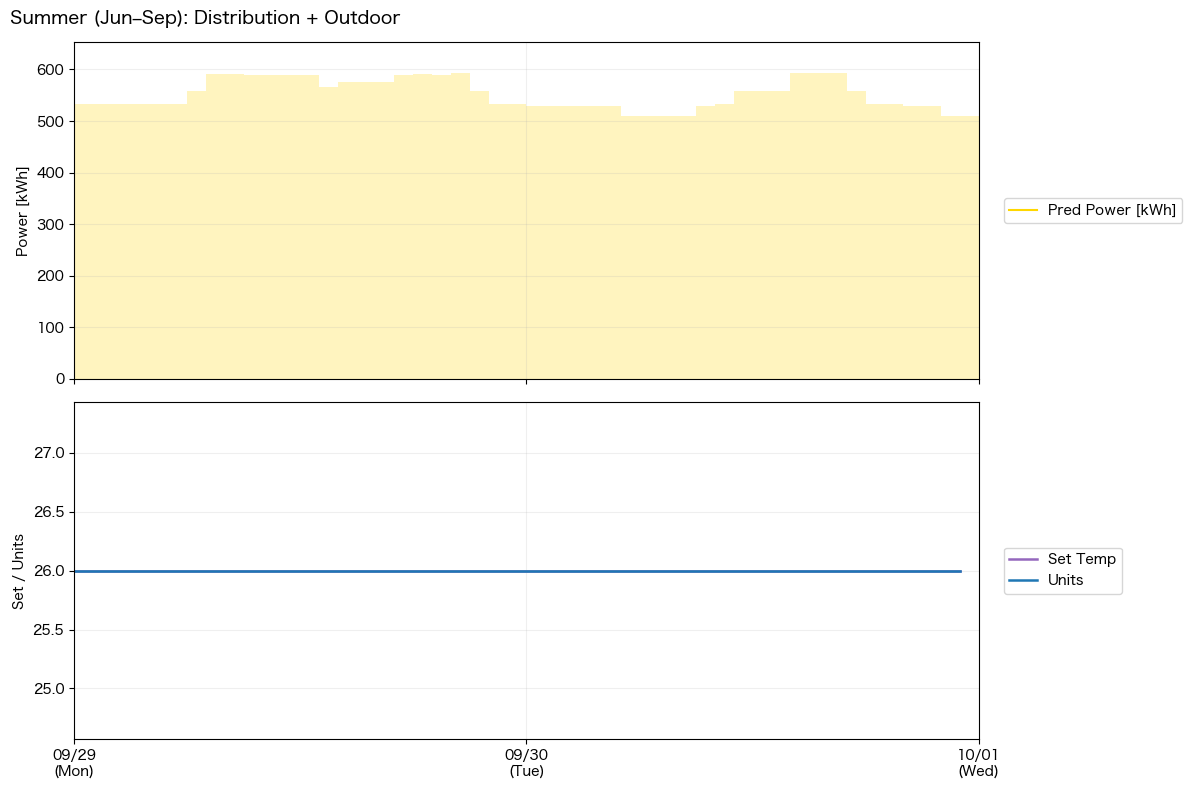

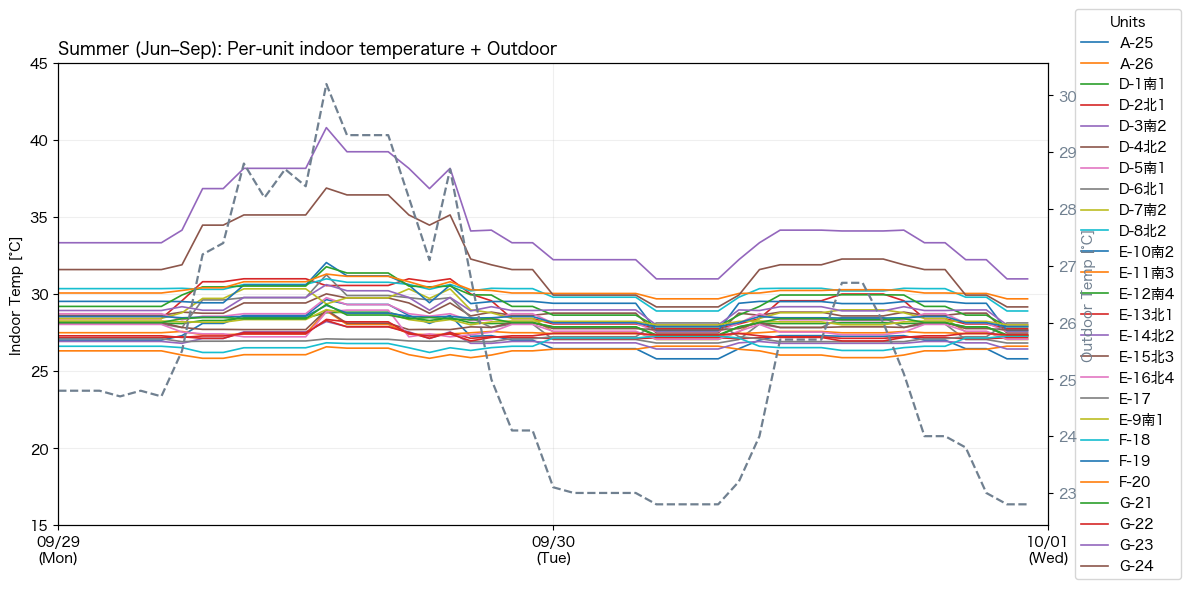

In [ ]:
# Summer-only visualization + add Outdoor Temp overlay to both figures

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# time axis and bar width
x = pd.to_datetime(uniform_plan['datetime'])
dt = pd.Series(x).diff().median()
if pd.isna(dt) or dt <= pd.Timedelta(0):
    dt = pd.Timedelta(hours=1)
width_days = dt / np.timedelta64(1, 'D')

# summer mask (Jun–Sep)
summer_mask = x.dt.month.isin([6, 7, 8, 9])

# outdoor series (from forecast)
outdoor_x = pd.to_datetime(fc_sorted['datetime'])
outdoor_series = pd.to_numeric(fc_sorted[fc_temp_col], errors='coerce')

# per-unit indoor temp columns
indoor_cols = [c for c in uniform_plan.columns if c.startswith('pred_indoor_temp__')]

if indoor_cols:
    # 1) Distribution + Outdoor (summer only)
    temp_mat = uniform_plan.loc[summer_mask, indoor_cols].apply(pd.to_numeric, errors='coerce')
    x_s = x[summer_mask]

    t_min = temp_mat.min(axis=1).values
    t_q1  = temp_mat.quantile(0.25, axis=1).values
    t_med = temp_mat.median(axis=1).values
    t_q3  = temp_mat.quantile(0.75, axis=1).values
    t_max = temp_mat.max(axis=1).values

    # align outdoor to summer range
    outdoor_mask = (outdoor_x >= x_s.min()) & (outdoor_x <= x_s.max())
    outdoor_x_s = outdoor_x[outdoor_mask]
    outdoor_s   = outdoor_series[outdoor_mask]

    plt.close('all')
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Power (summer only)
    ax[0].bar(x_s, uniform_plan.loc[summer_mask, 'pred_power_kwh'],
              width=width_days, align='edge', color='gold', alpha=0.25, linewidth=0)
    ax[0].plot([], [], color='gold', label='Pred Power [kWh]')
    ax[0].set_ylabel('Power [kWh]')
    ax[0].legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    if np.isfinite(np.nanmax(uniform_plan.loc[summer_mask, 'pred_power_kwh'])):
        ax[0].set_ylim(0, np.nanmax(uniform_plan.loc[summer_mask, 'pred_power_kwh']) * 1.1)

    # Set / Units (summer only)
    ax[1].plot(x_s, uniform_plan.loc[summer_mask, 'set_temp_uniform'],
               color='tab:purple', label='Set Temp', lw=1.8)
    ax[1].step(x_s, uniform_plan.loc[summer_mask, 'units_on_uniform'],
               where='post', color='tab:blue', label='Units', lw=1.8)
    ax[1].set_ylabel('Set / Units')
    ax[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    for a in ax:
        a.grid(True, alpha=0.2)
    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n(%a)'))
    ax[-1].xaxis.set_major_locator(mdates.DayLocator())
    ax[-1].set_xlim(x_s.min(), x_s.max() + dt)
    fig.suptitle('Summer (Jun–Sep): Distribution + Outdoor', fontsize=13, ha='left', x=0.01)
    plt.tight_layout()
    plt.show()

    # 2) Per-unit lines + Outdoor (summer only, one legend entry per unit)
    unit_names = [c.split('__', 1)[1] for c in indoor_cols]
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True)
    for col, name in zip(indoor_cols, unit_names):
        ax.plot(x_s, pd.to_numeric(uniform_plan.loc[summer_mask, col], errors='coerce'),
                lw=1.2, label=name)
    ax.set_ylabel('Indoor Temp [°C]')
    ax.set_ylim(15, 45)  # summer view range
    ax.grid(True, alpha=0.2)

    ax2 = ax.twinx()
    ax2.plot(outdoor_x_s, outdoor_s, color='slategrey', lw=1.6, ls='dashed', label='Outdoor Temp')
    ax2.set_ylabel('Outdoor Temp [°C]', color='slategrey')
    ax2.tick_params(axis='y', labelcolor='slategrey')

    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), title='Units')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n(%a)'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.set_xlim(x_s.min(), x_s.max() + dt)
    ax.set_title('Summer (Jun–Sep): Per-unit indoor temperature + Outdoor', loc='left')
    plt.tight_layout()
    plt.show()
else:
    print("No per-unit indoor temperature columns (pred_indoor_temp__*) were found in uniform_plan.")

___
**その他：電力実績確認**

室外機数: 21
期間: 2024-06-30 15:00:00 ～ 2025-09-28 01:00:00
室外機一覧: ['41-1', '43-1', '43-2', '43-3', '43-4', '44-1', '44-2', '44-3', '44-4', '44-5', '44-6', '44-7', '44-8', '49-1', '49-2', '49-3', '49-4', '49-6', '49-7', '49-8', '49-9']


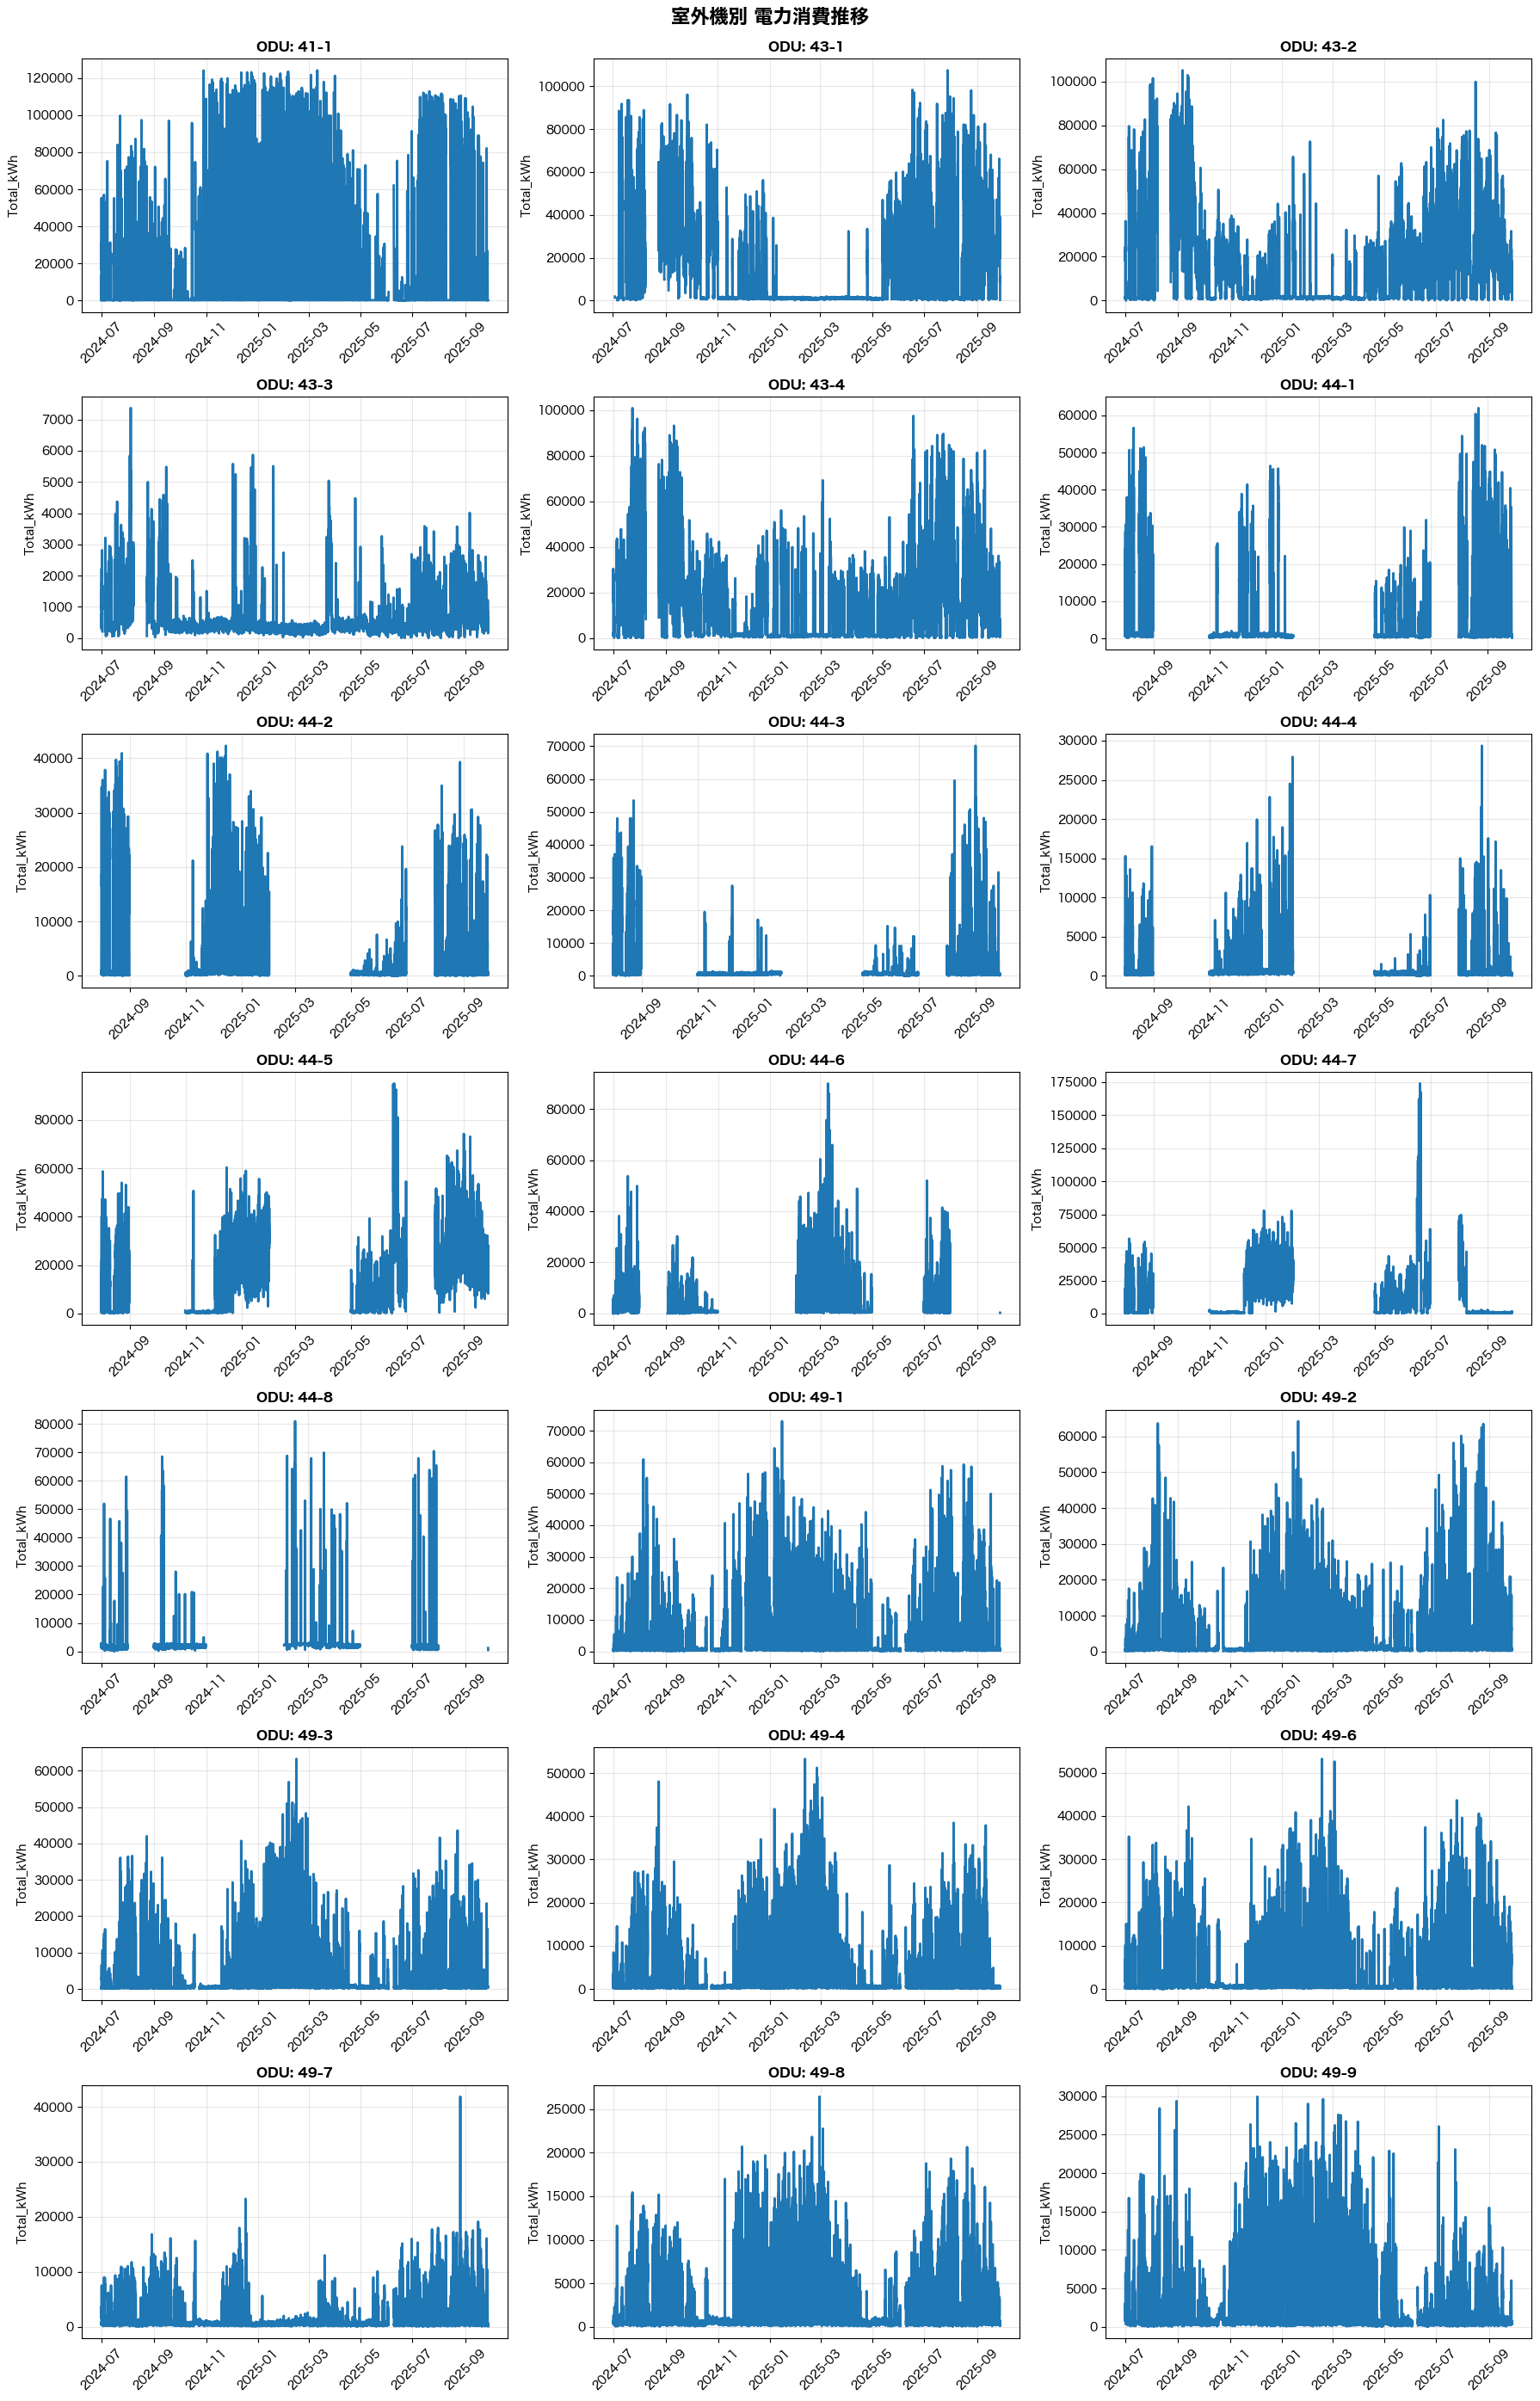

In [209]:
pw# pw データを室外機ごと（Mesh ID + PM Addr ID）に横持ち変換
# Total_kWh 列のみを参照

# 1) 室外機IDの作成
pw['ODU_ID'] = pw['Mesh ID'].astype(str) + '-' + pw['PM Addr ID'].astype(str)

# 2) 時刻で時単位に丸め（既に丸まっている場合はそのまま）
pw['Datetime'] = pd.to_datetime(pw['Datetime'])
pw['Datetime_hourly'] = pw['Datetime'].dt.floor('H')

# 3) 室外機×時刻で集約（Total_kWh を合計または平均）
# 同じ室外機・時刻のレコードが複数ある場合は合計を取る
pw_grouped = pw.groupby(['Datetime_hourly', 'ODU_ID'])['Total_kWh'].sum().reset_index()

# 4) 横持ちに変換
pw_wide = pw_grouped.pivot(index='Datetime_hourly', columns='ODU_ID', values='Total_kWh')
pw_wide = pw_wide.sort_index()

print(f'室外機数: {len(pw_wide.columns)}')
print(f'期間: {pw_wide.index.min()} ～ {pw_wide.index.max()}')
print(f'室外機一覧: {sorted(pw_wide.columns.tolist())}')


# 室外機ごとにサブプロットで可視化
n_odu = len(pw_wide.columns)
n_cols = 3
n_rows = (n_odu + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten() if n_odu > 1 else [axes]

for idx, odu_id in enumerate(sorted(pw_wide.columns)):
    ax = axes[idx]
    ax.plot(pw_wide.index, pw_wide[odu_id], linewidth=2, color='tab:blue')
    ax.set_title(f'ODU: {odu_id}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Total_kWh', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# 余ったサブプロットを非表示
for idx in range(n_odu, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('室外機別 電力消費推移', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()